In [1]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
%matplotlib inline

In [2]:
data = np.loadtxt("pilo_pyr3_05022017_clean.txt")

data = data[:, 1][::100] 

train = data[:-77648]
test =  data[-77648:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [4]:
lstm_train = data[:-77648]
lstm_test =  data[-77648:]

mean = lstm_train.mean()
std = lstm_train.std()
#sigmastest = np.abs(test - mean)
train_norm = (lstm_train - mean)/std
test_norm = (lstm_test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [5]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [6]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

In [7]:
model_lstm = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model_lstm = model_lstm.to('cuda')

In [9]:
def run_epoch(model, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

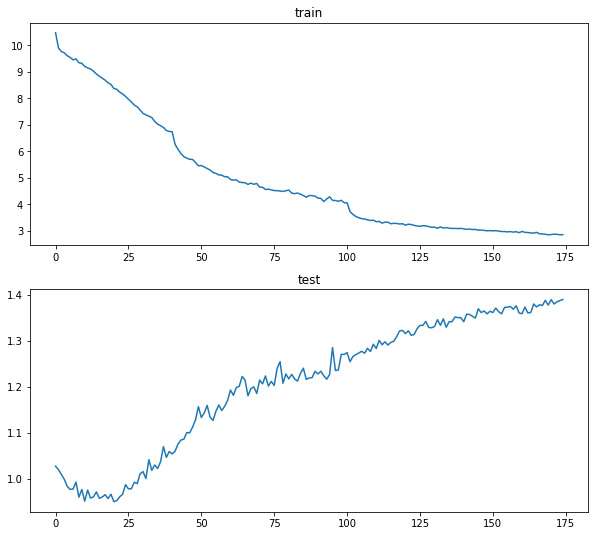

Epoch[175/175] | loss train:2.855047, test:1.389725


In [10]:
# define optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
lr = 0.001
epochs = 175

losses_train = []
losses_test = []
best_loss = 10e9

# begin training
for epoch in range(epochs): 
    if epoch > 20:
        lr = 0.0005
    if epoch > 100:
        lr = 0.0001
    optimizer = optim.Adam(model_lstm.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9)    
    loss_train = run_epoch(model_lstm, train_dataloader, is_training=True)
    loss_val = run_epoch(model_lstm, test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        torch.save(model_lstm.state_dict(), "./LSTMMiseData")
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [8]:
model_lstm.load_state_dict(torch.load("./LSTMMiseData"))

<All keys matched successfully>

In [9]:
def GetRmse(model, train_dataloader, val_dataloader, lstm_test, std, mean):
    model.eval()

    rmse = []
    
    lstm_predicts = []
    for k in tqdm(range(1, 20)):
        test_right_part = (len(lstm_test)- 20)%64
        predicted_val = np.array([])
        for idx, (x, y) in enumerate(val_dataloader):
            x = torch.reshape(x, (64, 20, 1)).to('cuda')
            cur_x = x
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                cur_x = torch.hstack((cur_x[:, 1:], torch.reshape(out, (64, 1, 1))))
            predicted_val = np.concatenate((predicted_val, cur_x[:, -1, 0].cpu().detach().numpy()))
            
        lstm_predicts.append(np.array(predicted_val)*std+mean)
        if k == 1:
            r = (((np.array(predicted_val)*std+mean - np.array(lstm_test[20:-test_right_part]))**2).mean())**0.5
        else:
            r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(lstm_test[20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse, lstm_predicts

In [10]:
rmse_chaos, lstm_predicts = GetRmse(model_lstm, train_dataloader, test_dataloader, lstm_test, std, mean)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [02:22<00:00,  7.49s/it]


In [11]:
np.save("predicts/lstm_rmse", np.array(rmse_chaos))
for i in range(len(lstm_predicts)):
    np.save("predicts/lstm_predict_" + str(i), lstm_predicts[i])

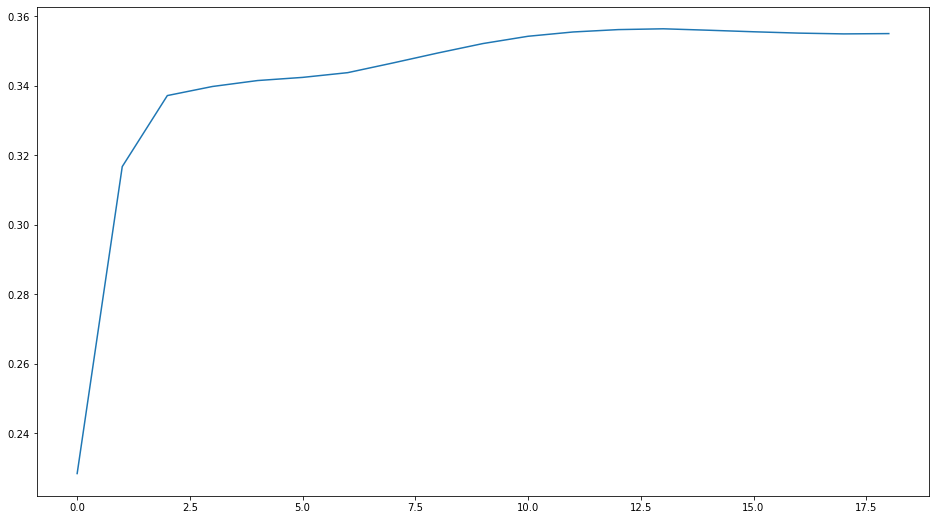

In [12]:
plt.figure(figsize=(16, 9))
plt.plot(rmse_chaos)

In [15]:
def Plt(k):
    #k = 5
    fig = plt.figure(figsize = (16, 16))
    
    
    plt.plot(lstm_test[20+k-1: 20+k-1 + 1000], label='true')
    plt.plot(lstm_predicts[k-1][:1000],  linestyle = '--', label='predicted')
    plt.legend()
    plt.title('LSTM')
    
    
    plt.show()
    

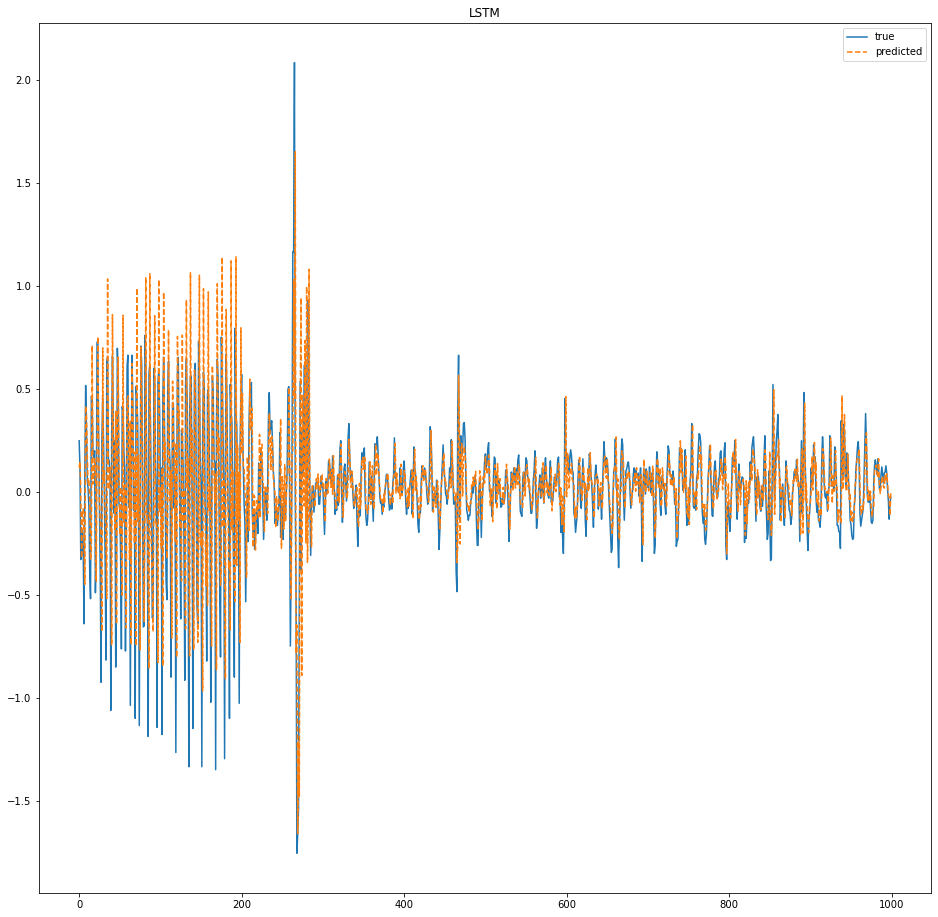

In [16]:
Plt(1)

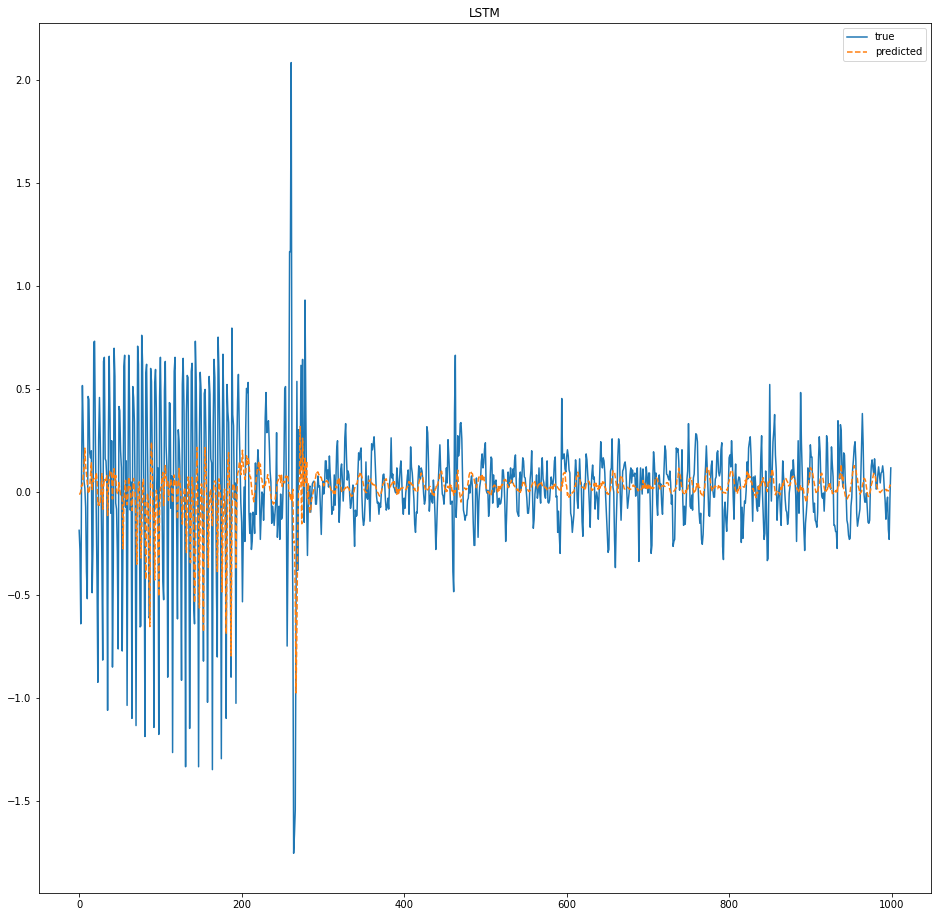

In [17]:
Plt(5)

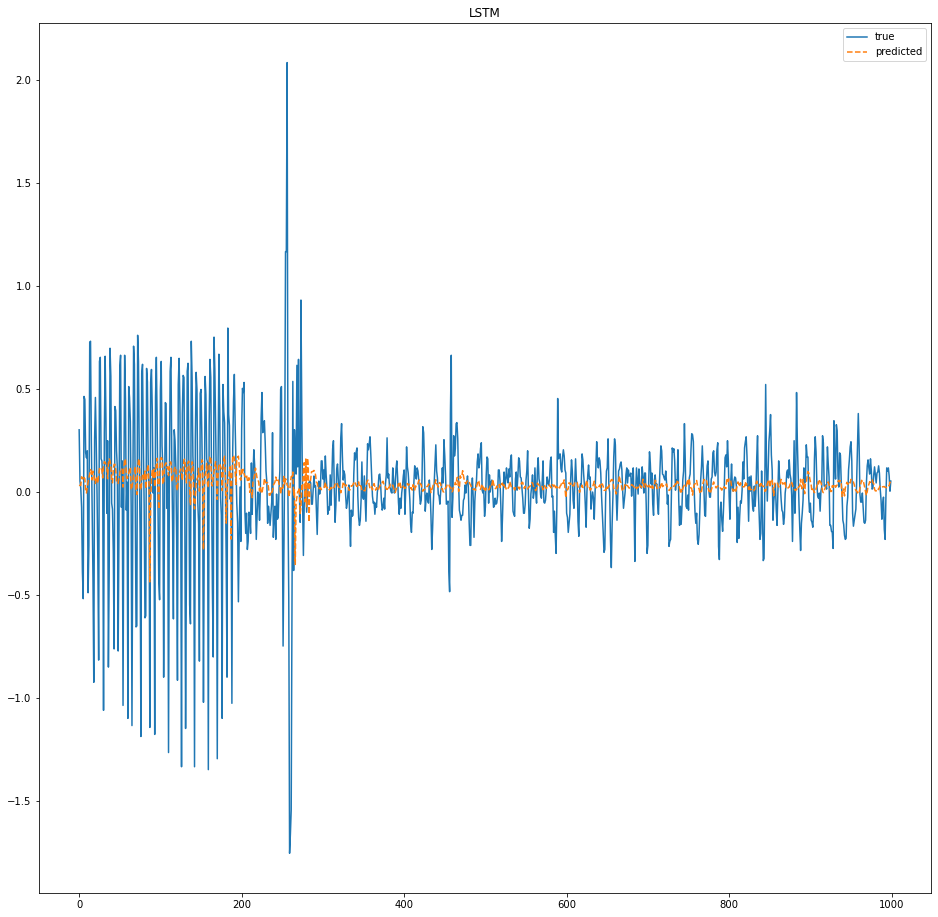

In [18]:
Plt(10)

In [19]:
def Calc_TP(predict, target, k, n, m):

    assert len(predict) == len(target)

    TP = 0
    i = n
    TP_lst = []
    while i < len(predict):
        if predict[i] > Hs:
            if (target[i - k + 1: i + n] > Hs).any() and (test[i-m: i - k + 1] < Hs).all():
                #print(i)
                TP_lst.append(i)
                i += n
                TP += 1
        i += 1
    return TP, TP_lst

In [20]:
def Calc_FN(predict, target, k, n, m):

    assert len(predict) == len(target)

    FN = 0
    i = n
    FN_lst = []
    while i < len(predict):
        if target[i] > Hs:
            if (predict[i - n: i + k] < Hs).all():
                #print(i)
                #return FN
                FN_lst.append(i)
                i += n
                FN += 1
        i += 1
    return FN, FN_lst

In [21]:
def Calc_FP(predict, target, k, n, m):

    assert len(predict) == len(target)

    FP = 0
    i = n
    FP_lst = []
    while i < len(predict):
        if predict[i] > Hs:
            if (target[i - n: i + n] < Hs).all():
                #print(i)
                #return FN
                FP_lst.append(i)
                i += n
                FP += 1
        i += 1
    return FP, FP_lst

In [24]:
Hs = mean + 4 * std

In [30]:
Hs

4.121258952957149

In [25]:
test_right_part = (len(test)- 20)%64
TPs_lstm = []

for i in range(19):
    
    if i:
        TP_lstm, _ = Calc_TP(lstm_predicts[i][:-i], test[20+i:-test_right_part], i+1, 50, 5 + i)
        TPs_lstm.append(TP_lstm)
    else:
        TP_lstm, _ = Calc_TP(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
        TPs_lstm.append(TP_lstm)
    

In [26]:
test_right_part = (len(test)- 20)%64
FNs_lstm = []

for i in range(19):
    
    if i:
        FN_lstm, _ = Calc_FN(lstm_predicts[i][:-i], test[20+i:-test_right_part], i+1, 50, 5 + i)
        FNs_lstm.append(FN_lstm)
    else:
        FN_lstm, _ = Calc_FN(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
        FNs_lstm.append(FN_lstm)
    

In [27]:
test_right_part = (len(test)- 20)%64
FPs_lstm = []

for i in range(19):

    if i:
        FP_lstm, _ = Calc_FP(lstm_predicts[i][:-i], test[20+i:-test_right_part], i+1, 50, 5 + i)
        FPs_lstm.append(FP_lstm)
    else:
        FP_lstm, _ = Calc_FP(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
        FPs_lstm.append(FP_lstm)
    

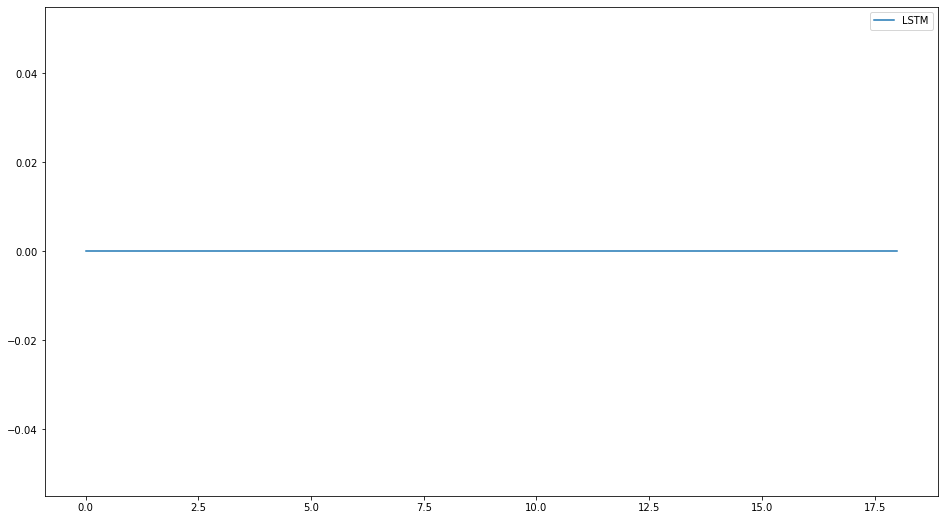

In [28]:
plt.figure(figsize=(16, 9))
plt.plot(TPs_lstm, label="LSTM")
plt.legend()

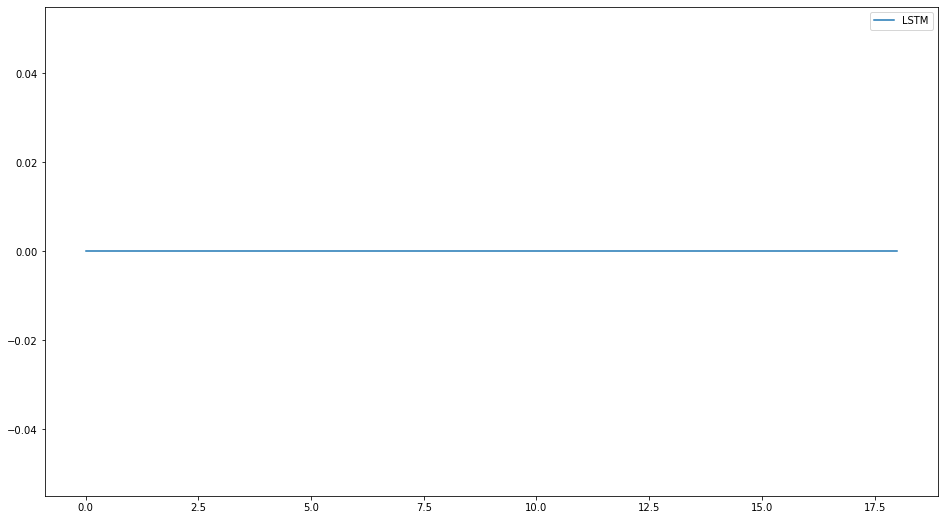

In [31]:
plt.figure(figsize=(16, 9))
plt.plot(FPs_lstm, label="LSTM")
plt.legend()

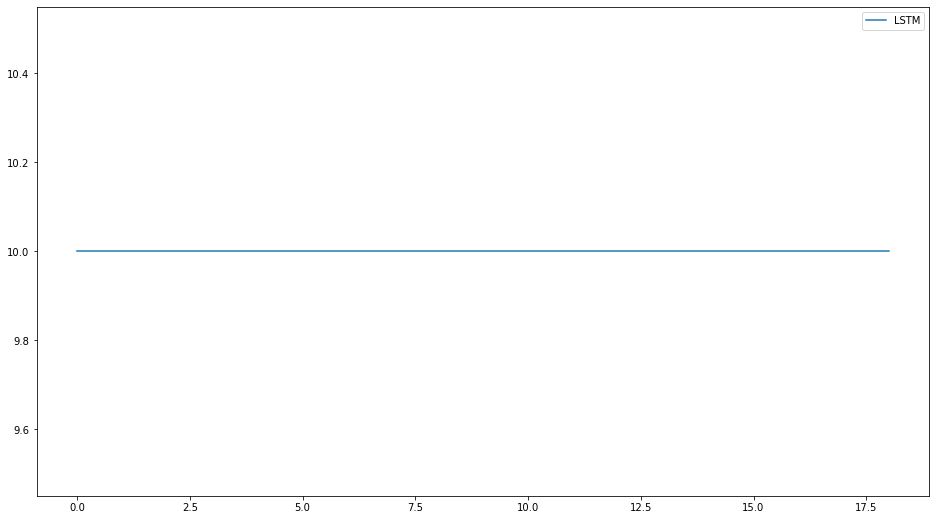

In [32]:
plt.figure(figsize=(16, 9))
plt.plot(FNs_lstm, label="LSTM")
plt.legend()

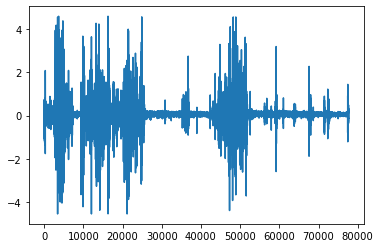

In [33]:
plt.plot(test)